In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("marketing_customer_analysis.csv")

numerical = pd.DataFrame()
categoricals = pd.DataFrame()

for column in df.columns:
    if df[column].dtype == 'object': 
        categoricals[column] = df[column]
    else:
        numerical[column] = df[column]

numerical.head()

,Customer Lifetime Value,Income,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Total Claim Amount
0,2763.519279,56274,69,32,5,0,1,384.811147
1,6979.535903,0,94,13,42,0,8,1131.464935
2,12887.431650,48767,108,18,38,0,2,566.472247
3,7645.861827,0,106,18,65,0,7,529.881344
4,2813.692575,43836,73,12,44,0,1,138.130879


<Axes: >

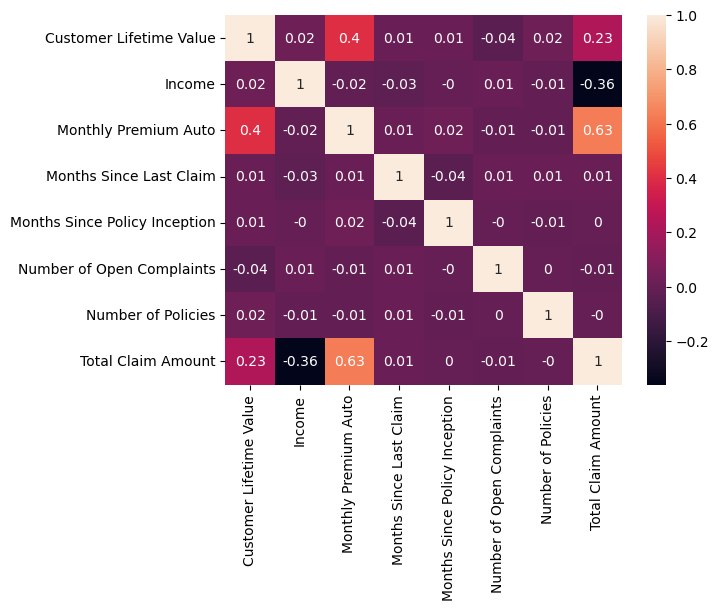

In [2]:
sns.heatmap(data=numerical.corr().round(2), annot=True)

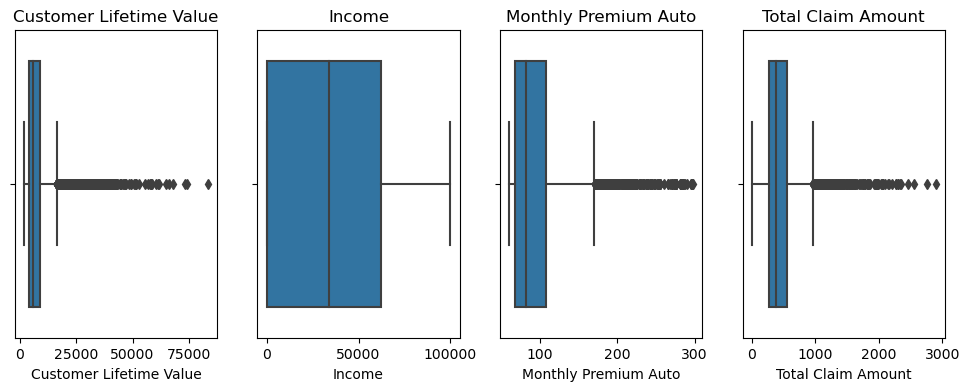

In [3]:
filtered = df[["Customer Lifetime Value", "Income", "Monthly Premium Auto", "Total Claim Amount"]]

fig, ax = plt.subplots(1, 4, figsize=(12, 4))

for i, column in enumerate(filtered.columns):
    sns.boxplot(x=filtered[column], ax=ax[i])
    ax[i].set_title(column)

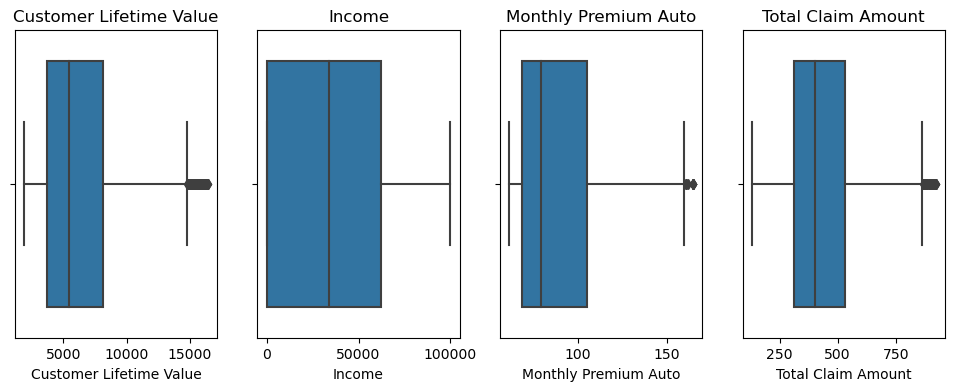

In [4]:
fig, ax = plt.subplots(1, 4, figsize=(12, 4))

for i, column in enumerate(filtered.columns):
    # Determine Whiskers of each plot
    iqr = np.percentile(filtered[column],75) - np.percentile(filtered[column],25)
    upper_limit = np.percentile(filtered[column],75) + 1.5*iqr
    lower_limit = np.percentile(filtered[column],75) - 1.5*iqr

    # Drop rows that exceed the whiskers
    filtered = filtered[(filtered[column]>lower_limit) & (filtered[column]<upper_limit)]

    sns.boxplot(x=filtered[column], ax=ax[i])
    ax[i].set_title(column)


In [5]:
from sklearn.model_selection import train_test_split

# Determine Y / X
y = filtered['Income']
X = filtered.drop(['Income'], axis=1)

# Create Test/Train Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
for dataFrame in [X_train, y_train]:
    print(dataFrame.skew())

Customer Lifetime Value    1.007679
Monthly Premium Auto       0.745879
Total Claim Amount         0.571796
dtype: float64
0.38252376664606036


In [7]:
X_train.describe()

# The values ranges are quite far from eachother, so a minmax scaler could be applied

,Customer Lifetime Value,Monthly Premium Auto,Total Claim Amount
count,5398.000000,5398.000000,5398.000000
mean,6084.133668,86.274361,425.508737
std,3110.986805,21.712281,168.607702
min,1898.007675,61.000000,129.999138
25%,3675.372208,68.000000,309.570964
50%,5332.143288,78.000000,398.400000
75%,8002.308333,104.000000,529.499725
max,16388.095420,165.000000,922.335972


In [8]:
from sklearn.preprocessing import MinMaxScaler
import pickle
import os


scaler = MinMaxScaler()
scaler.fit(X_train)


path = "transformers-scalers/"

isExist = os.path.exists(path)
if not isExist:
    
    os.makedirs(path)
    print("The new directory is created")

filename = "minMaxScaler.pkl" 
with open(path+filename, "wb") as file:
    pickle.dump(scaler, file) 


X_train_scaled = scaler.transform(X_train) 
X_test_scaled  = scaler.transform(X_test) 


X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled_df  = pd.DataFrame(X_test_scaled,  columns=X_train.columns)

X_train_scaled_df.head()

,Customer Lifetime Value,Monthly Premium Auto,Total Claim Amount
0,0.255600,0.125000,0.284224
1,0.438803,0.076923,0.037085
2,0.288713,0.250000,0.626502
3,0.241551,0.057692,0.241817
4,0.258507,0.105769,0.272108


In [9]:
from sklearn.linear_model import LinearRegression

LinearReg = LinearRegression()

LinearReg.fit(X_train_scaled_df, y_train)

path = "models/"

isExist = os.path.exists(path)

if not isExist:

    os.makedirs(path)
    print("The new directory is created")

filename = "LinearReg.pkl" 
with open(path+filename, "wb") as file:
    pickle.dump(LinearReg, file)

In [10]:
y_train_pred = LinearReg.predict(X_train_scaled_df)
y_test_pred = LinearReg.predict(X_test_scaled_df)

In [11]:
y_train_pred = LinearReg.predict(X_train_scaled_df)
y_test_pred = LinearReg.predict(X_test_scaled_df)
results = {"Set": ["Train"]*X_train.shape[0] + ["Test"]*X_test.shape[0], 
           "Real": list(y_train) + list(y_test),
           "Predicted": list(y_train_pred) + list(y_test_pred)}

results_df = pd.DataFrame(results)
results_df.head()

,Set,Real,Predicted
0,Train,11920,37430.439445
1,Train,62902,54148.043604
2,Train,0,18857.305192
3,Train,73775,37737.924750
4,Train,41043,37576.872626


In [12]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def error_metrics_report(y_real_train: list, y_real_test: list, y_pred_train: list, y_pred_test: list) -> pd.DataFrame:

        
        MAE_train = mean_absolute_error(y_real_train, y_pred_train)
        MAE_test  = mean_absolute_error(y_real_test,  y_pred_test)

       
        MSE_train = mean_squared_error(y_real_train, y_pred_train)
        MSE_test  = mean_squared_error(y_real_test,  y_pred_test)

        
        RMSE_train = mean_squared_error(y_real_train, y_pred_train, squared=False)
        RMSE_test  = mean_squared_error(y_real_test, y_pred_test, squared=False)

        # R2
        R2_train = r2_score(y_real_train, y_pred_train)
        R2_test  = r2_score(y_real_test,  y_pred_test)

        results = {"Metric":["MEA", "MSE", "RMSE", "R2"], 
                "Train": [MAE_train, MSE_train, RMSE_train, R2_train],
                "Test":  [MAE_test, MSE_test, RMSE_test, R2_test]}

        return pd.DataFrame(results).round(2)

In [13]:
error_metrics_report(list(results_df[results_df["Set"]=="Train"]["Real"]),
                     list(results_df[results_df["Set"]=="Test"]["Real"]),
                     list(results_df[results_df["Set"]=="Train"]["Predicted"]),
                     list(results_df[results_df["Set"]=="Test"]["Predicted"]))

,Metric,Train,Test
0,MEA,2.251912e+04,2.257388e+04
1,MSE,7.461520e+08,7.456665e+08
2,RMSE,2.731578e+04,2.730690e+04
3,R2,1.800000e-01,1.700000e-01
